In [1]:
%pylab inline
import ROOT
import root_numpy
import pandas as pd
import glob
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyAmsUtils import *

In [3]:
filenames = sorted(glob.glob("/data/13*.root"), key=os.path.getmtime)[:-1]
mcnames = sorted(glob.glob("/data/deuteronMC*.root"), key=os.path.getmtime)

def get_bits_names(f):
    tfile = ROOT.TFile(filenames[0]) 
    return str(tfile.Get("infos/selectionBits").GetString()).split(',')

selBits = get_bits_names(filenames[0])

def get_frame(f, branches=None):
    tfile = ROOT.TFile(f)
    tree  = tfile.Get("selections")
    return tree_to_frame(tree, branches=branches) 

In [4]:
def extract_ntrd(fStatus):
    (fStatus >> 8) & 0b11

def make_sel_table(data):
    """ Creates rigidity bins and expands bit fields to bool series """
    selTable = {}
    
    # Binning stuff
    data['Mass'] = get_mass(data['R'], data['BetaTOF'])
    for c,mx in [('R',20), ('Latitude',1), ('Mass',3)]:
        bins = np.linspace(0,mx,101)
        selTable[c+'_bin'] = pd.cut(data[c], bins=bins, labels=bins[:-1])
    
    # Expanding bits
    for i,name  in enumerate(selBits):
        selTable[name] = (data['selStatus'] & (1<<i) ) != 0
    
    selTable['oneTRDTrack'] = data['fStatus'].map(lambda x: ((x >> 8) & 0b11) == 1)
    selTable['physTrigg'  ] = data['PhysBPatt'] == 2 
    selTable['unbsTrigg'  ] = data['PhysBPatt'] == 0 
    selTable = pd.DataFrame(selTable)

    # Creating agregate vars
    for new in ['minimumbias', 'golden']:
        selTable[new] = True
        for c in selBits: 
            if c.startswith(new): 
                selTable[new] &= selTable[c]
    return selTable

def get_ind_counts(selTable, columns):
    """ Creates counts table"""
    csort = lambda s: s.value_counts().sort_index()
    counts = pd.DataFrame({'Total':csort(selTable['R_bin'])})
    for c in columns:
        counts[c] = csort(selTable['R_bin'][selTable[c]])
    return counts

def sum_counts(filenames):
    counts = None
    progress= Progress(80, len(filenames))
    for i,f in enumerate(filenames):
        progress.step(i)
        data = get_frame(f)
        selTable = make_sel_table(data)
        selTable['Total'] = True
        idx = [c for c in selTable.columns if c.endswith("_bin")]
        get_ind_counts = selTable.groupby(idx).sum().dropna()
        if counts is None: 
            counts = get_ind_counts
        else:
            counts = counts.add(get_ind_counts, fill_value=0)
    return counts

# Data

In [61]:
d['notInSaaCut'] == d['Total']

In [5]:
d = sum_counts(filenames[:3])

---
--

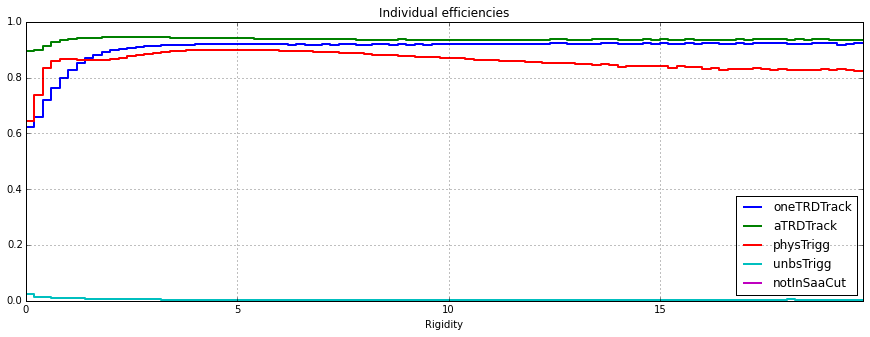

In [59]:
counts = d.reset_index().groupby('R_bin').sum()
figsize(15,5)
columns = ['oneTRDTrack', 'aTRDTrack', 'physTrigg', 'unbsTrigg', 'notInSaaCut']
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

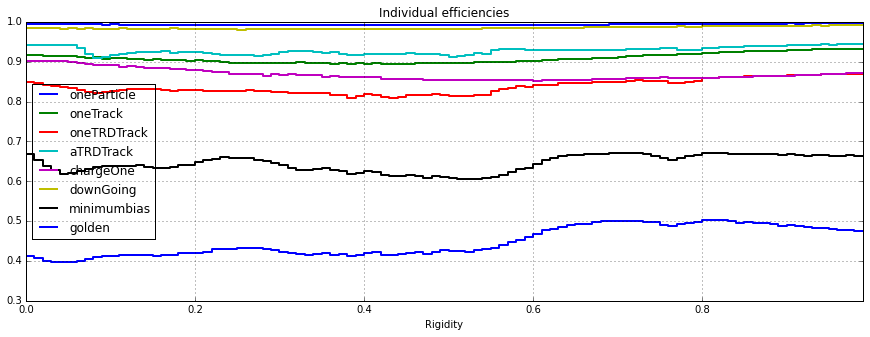

In [45]:
counts = d.reset_index().groupby('Latitude_bin').sum()
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'oneTRDTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

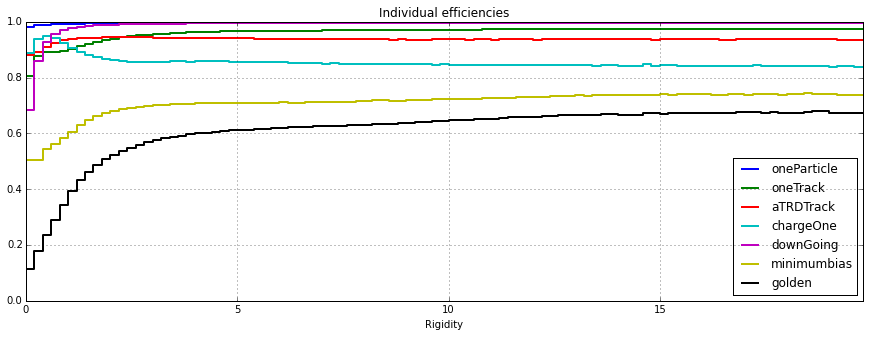

In [7]:
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

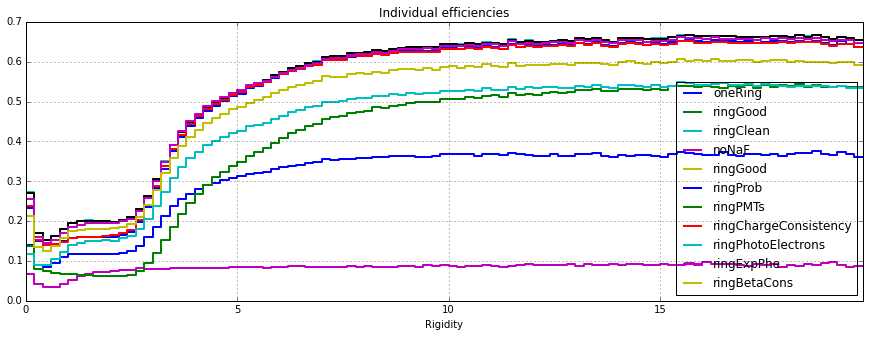

In [136]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

# D Monte Carlo

In [30]:
mccounts = sum_counts(mcnames)

---
--

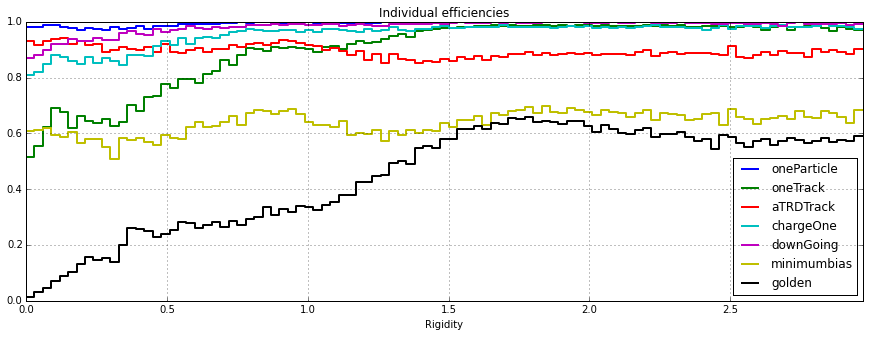

In [32]:
counts = mccounts.reset_index().groupby('Mass_bin').sum()
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
counts[columns].divide(counts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

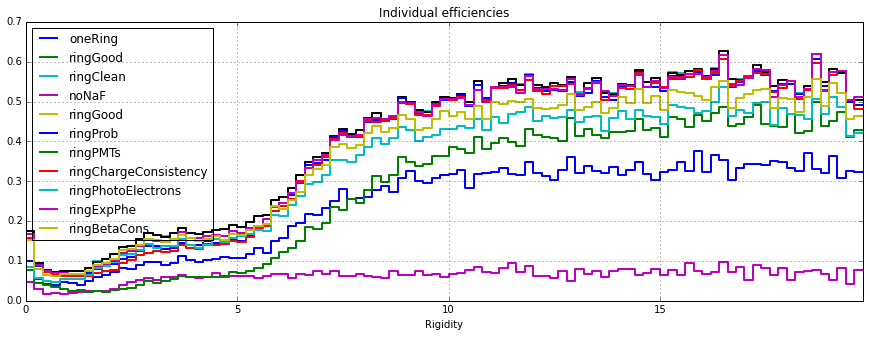

In [144]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
mccounts[columns].divide(mccounts['Total'],axis=0).plot(drawstyle='steps', lw=2)
xlabel('Rigidity')
title('Individual efficiencies ')

# Fraction

In [155]:
effData =   counts.divide(  counts['Total'],axis=0)
effMC   = mccounts.divide(mccounts['Total'],axis=0)
effFr   = (effMC-effData)

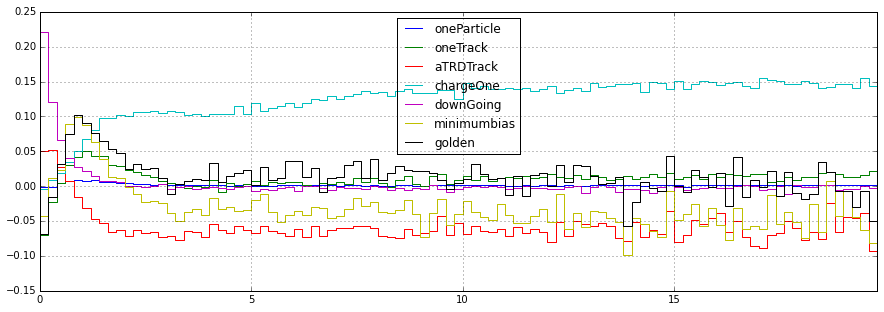

In [156]:
figsize(15,5)
columns = ['oneParticle', 'oneTrack', 'aTRDTrack', 'chargeOne', 'downGoing', 'minimumbias', 'golden']
effFr[columns].plot(drawstyle='steps')

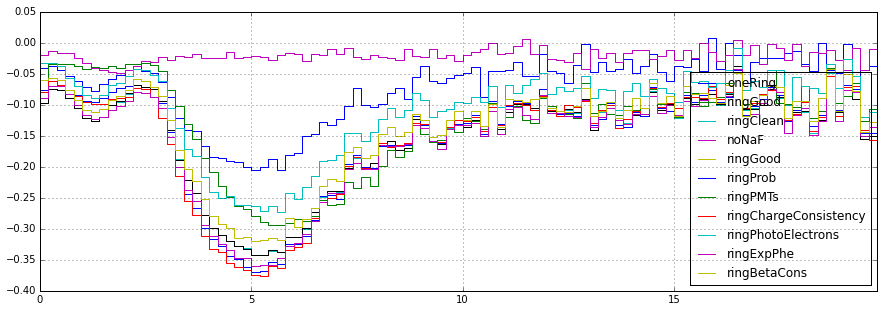

In [157]:
columns = ['oneRing','ringGood', 'ringClean', 'noNaF',
           'ringGood',  'ringProb', 'ringPMTs',
           'ringChargeConsistency', 'ringPhotoElectrons',
           'ringExpPhe', 'ringBetaCons',]
effFr[columns].plot(drawstyle='steps')